In [41]:
#데이터 핸들링에 사용되는 라이브러리
import pandas as pd
import numpy as np

#데이터 시각화 라이브러리
import seaborn as sns
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.family':'AppleGothic'})
mpl.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'
from scalecast.Forecaster import Forecaster
import pickle

#머신러닝 라이브러리
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator


#정규화 라이브러리
from sklearn.preprocessing import StandardScaler,MinMaxScaler

#평가 라이브러리
from sklearn.metrics import mean_squared_error

#CPU만 작동하게 하는 명령어(for Mac)
tf.config.list_physical_devices()
tf.config.experimental.set_visible_devices([], 'GPU')

#머신러닝 평가에 사용되는 보조
from sklearn import model_selection
from keras import models,layers
from keraspp import skeras


In [42]:
#파일 불러오기
#2017~2019년도
df = pd.read_csv('./LSTM_데이터/서울사고건수(2017~2019).csv')
#아래 데이터와 2017년도가 겹치므로 18~19년도만 선택하면
df= df.iloc[365:]

#2015~2017년도
#18~19년도 데이터 형식에 맞게 전처리
df2= pd.read_excel('./LSTM_데이터/서울발생건수(2015~2017).xlsx')
df2.drop(['Unnamed: 0','발생시도'],axis=1,inplace=True)
df2.rename({'계':'사고건수'},axis=1,inplace=True)

#날짜를 datatime으로 변환하기 위해선 20XX-XX-XX형식으로 맞출 필요가 있는걸로 보임
#따라서 그에 적절하게 형태를 바꿈
year_lst=[]
month_lst=[]
day_lst=[]
str_date_lst=[]

for i in range(len(df2['발생일'])):
    year_lst.append(str(df2['발생일'][i])[:4])
    month_lst.append(str(df2['발생일'][i])[4:6])
    day_lst.append(str(df2['발생일'][i])[6:])
    str_date_lst.append(year_lst[i]+'-'+month_lst[i]+'-'+day_lst[i]+' '+'00:00:00')
df2['발생일']=str_date_lst


df= pd.concat([df2,df])
df['발생일']=pd.to_datetime(df['발생일'])
print(df.info())
df.sort_values(by='발생일')
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   발생일     1826 non-null   datetime64[ns]
 1   사고건수    1826 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 42.8 KB
None


,발생일,사고건수
0,2015-01-01,62
1,2015-01-02,64
2,2015-01-03,94
3,2015-01-04,86
4,2015-01-05,123
...,...,...
1821,2019-12-27,94
1822,2019-12-28,94
1823,2019-12-29,78
1824,2019-12-30,91


In [43]:
df.describe()

,사고건수
count,1826.000000
mean,108.642935
std,20.312264
min,38.000000
25%,96.000000
50%,110.000000
75%,122.000000
max,193.000000


## 분포 확인

In [44]:
#교육 및 예측을 수행하기 전에 데이터가 어떻게 표시되는지 plotly 사용하여 시각화
print("Plotly Version: ",plotly.__version__)

trace = go.Scatter(
    x = df['발생일'],
    y = df['사고건수'],
    mode = 'lines',
    name = 'Data'
)
layout = go.Layout(
    title = "",
    xaxis = {'title' : "발생일"},
    yaxis = {'title' : "사고건수"}
)
fig = go.Figure(data=[trace], layout=layout)
fig.show()


Plotly Version:  5.9.0


In [45]:
# split data into train and test-sets
split_percent = 0.75
train_test_split = int(split_percent*len(df))


# create a differenced series

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons,activation='relu'
                    ,batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(layers.Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=10, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

def forecast_lstm(model, batch_size, X):
    #개선 없을시 조기 학습종료를 위한 라이브러리
    #50회를 관찰에도 성능향상이 없을시 종료로 설정
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor = 'loss', min_delta = 0, patience = 50, mode = 'auto')

    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size,callbacks=early_stopping)

    return yhat[0,0]


In [46]:
# transform data to be stationary
df_target = df['사고건수']

raw_values = df_target.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning

supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

train, test = supervised_values[:train_test_split], supervised_values[train_test_split:]
len(train)

print(f'train의 크기는 {train.shape} test의 크기는 {test.shape}입니다')

# transform the scale of the data

scaler, train_scaled, test_scaled = scale(train, test)

# fit the model

lstm_model = fit_lstm(train_scaled, 1, 10, 64)

# forecast the entire training dataset to build up state for forecasting

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data

predictions = []
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]


# report performance
rmse = np.sqrt(mean_squared_error(raw_values[train_test_split+1:], predictions))
print('Test RMSE: %.3f' % rmse)

# line plot of observed vs predicted
predictions=[0 for i in range(len(train)+1)] +predictions

df1 = pd.DataFrame(raw_values)
df2 = pd.DataFrame(predictions)


pdlist=[df1,df2]
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

df = pd.concat(pdlist, axis=1)
df.columns=['Actual Values','Predicted Values']
df


train의 크기는 (1369, 2) test의 크기는 (456, 2)입니다
Epoch 1/10
1369/1369 [==============================] - 1s 442us/step - loss: 0.0764
Epoch 2/10
1369/1369 [==============================] - 1s 446us/step - loss: 0.0685
Epoch 3/10
1369/1369 [==============================] - 1s 432us/step - loss: 0.0687
Epoch 4/10
1369/1369 [==============================] - 1s 429us/step - loss: 0.0657
Epoch 5/10
1369/1369 [==============================] - 1s 434us/step - loss: 0.0668
Epoch 6/10
1369/1369 [==============================] - 1s 460us/step - loss: 0.0648
Epoch 7/10
1369/1369 [==============================] - 1s 478us/step - loss: 0.0642
Epoch 8/10
1369/1369 [==============================] - 1s 424us/step - loss: 0.0624
Epoch 9/10
1369/1369 [==============================] - 1s 460us/step - loss: 0.0625
Epoch 10/10
1369/1369 [==============================] - 1s 453us/step - loss: 0.0642
Epoch 1/10
1369/1369 [==============================] - 1s 468us/step - loss: 0.0627
Epoch 2/10
1369/1369 

,Actual Values,Predicted Values
0,62,0.000000
1,64,0.000000
2,94,0.000000
3,86,0.000000
4,123,0.000000
...,...,...
1821,94,97.479990
1822,94,100.197850
1823,78,100.900360
1824,91,95.276258


In [47]:
df_pred= df.iloc[len(train)+1:,:]
df_pred.reset_index(inplace=True)
df_pred.drop('index',axis=1,inplace=True)
df_pred

,Actual Values,Predicted Values
0,127,95.109145
1,98,105.209594
2,121,89.959742
3,160,112.838426
4,136,126.502317
...,...,...
451,94,97.479990
452,94,100.197850
453,78,100.900360
454,91,95.276258


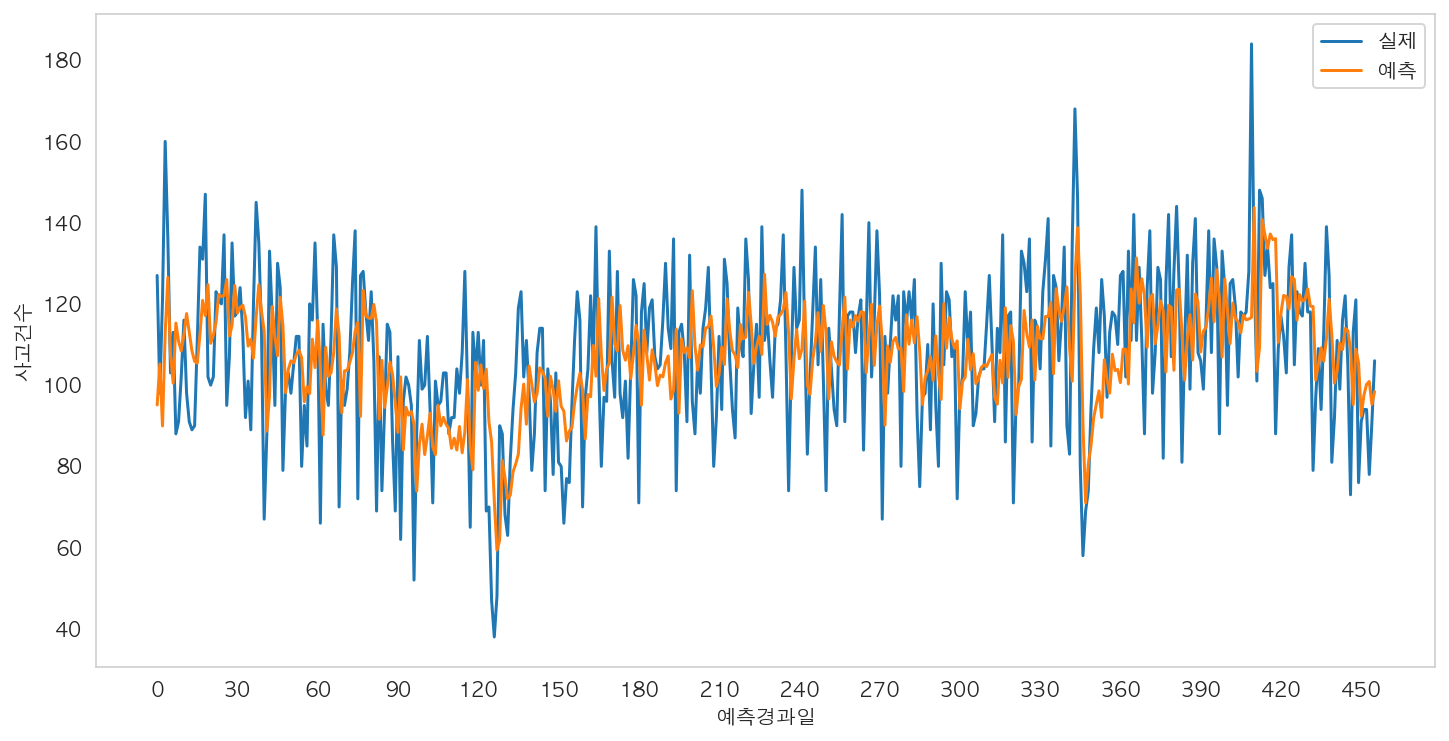

In [48]:
plt.figure(figsize=(12, 6))
plt.xlabel('예측경과일')
plt.ylabel('사고건수')
plt.xticks(np.arange(0,len(df_pred),30))
plt.plot(df_pred['Actual Values'], label='actual')
plt.plot(df_pred['Predicted Values'], label='prediction')
plt.grid()
plt.legend(['실제','예측'],loc='best')
plt.show()


평균 오차율은 15.32% 입니다


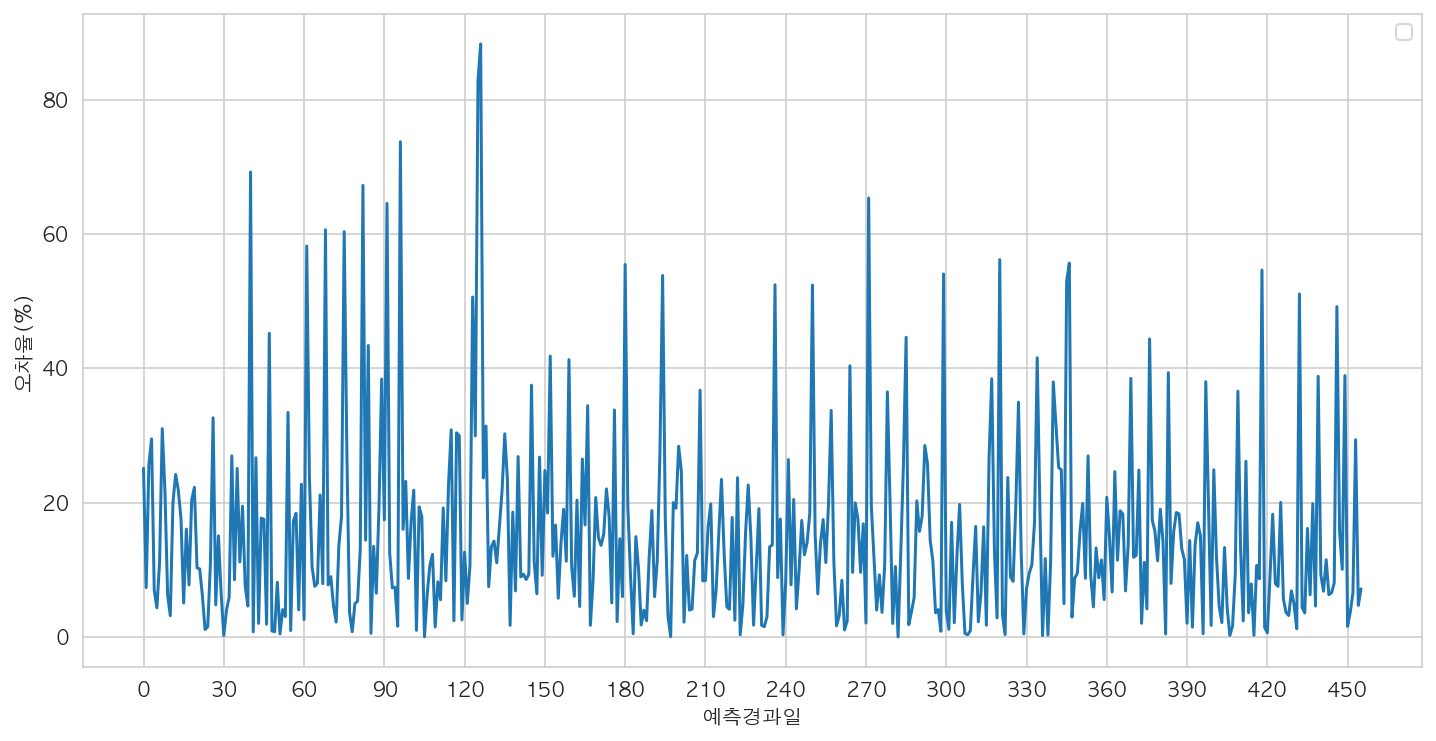

In [49]:
#오차율과 평균 오차율 구하기
error_percentage=np.abs((df_pred['Actual Values']-df_pred['Predicted Values'])/df_pred['Actual Values'])*100
avg_error_percentage= np.average(error_percentage)

plt.figure(figsize=(12, 6))
plt.xlabel('예측경과일')
plt.ylabel('오차율(%)')
plt.xticks(np.arange(0,len(df_pred),30))
plt.plot(error_percentage)
print(f'평균 오차율은 {avg_error_percentage:.2f}% 입니다')
plt.grid()
plt.legend(loc='best')
plt.grid()
plt.show()